# Data Acquisition

### Import librerie utili sezione

In [1]:
import pandas as pd
import os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
import numpy as np

# Preprocessing

In [2]:
file_path = "../../train.csv"
df = pd.read_csv(file_path)

In [3]:
clean_df = df.dropna() 
clean_df = df.drop_duplicates()

In [4]:
# Itera su ogni anno presente nel DataFrame
for year in clean_df['Year'].unique():
    # Filtra il DataFrame per l'anno corrente
    df_year = clean_df[clean_df['Year'] == year]
    
    # Calcola la mediana per ogni colonna
    median_values = df_year.median()
    
    # Calcola i limiti per individuare gli outlier per ogni colonna
    Q1 = df_year.quantile(0.25)
    Q3 = df_year.quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    # Sostituisci gli outlier con la mediana per ogni colonna
    def replace_outliers(row):
        for col in df_year.columns[1:]:  # Escludi la colonna 'year'
            if row[col] < lower_limit[col] or row[col] > upper_limit[col]:
                row[col] = median_values[col]
        return row
    
    df_year = df_year.apply(replace_outliers, axis=1) # Sostituzione outlier con mediana
    
    # Sostituisci i dati nel DataFrame originale
    clean_df.loc[clean_df['Year'] == year] = df_year

In [5]:
file_path = "../outliers_data/df_outliers.csv"
df_outliers = pd.read_csv(file_path)

In [6]:
# Seleziona solo le colonne che iniziano con 'S'
colonne_s = [col for col in df.columns if col.startswith('S')]

# Lista per memorizzare i risultati
risultati_nuovi_outliers = []

# Ciclo attraverso ogni colonna 'S'
for col in colonne_s:
    # Calcola i quantili e l'IQRs (Interquartile Range)
    q1 = clean_df[col].quantile(0.25)
    q3 = clean_df[col].quantile(0.75)
    iqr = q3 - q1
    
    # Calcola i baffi inferiori e superiori
    baffo_inferiore = q1 - 1.5 * iqr
    baffo_superiore = q3 + 1.5 * iqr
    
    # Trova gli outliers inferiori e superiori
    outliers_inferiori = clean_df[clean_df[col] < baffo_inferiore]
    outliers_superiori = clean_df[clean_df[col] > baffo_superiore]
    numero_outliers = len(outliers_inferiori) + len(outliers_superiori)
    
    # Calcola la percentuale di outliers
    percentuale_outliers = (numero_outliers / len(df)) * 100
    
    # Aggiungi i risultati alla lista
    risultati_nuovi_outliers.append({
        'Colonna': col,
        'Numero Outliers': numero_outliers,
        'Percentuale Outliers': f'{percentuale_outliers:.2f}%'
    })

# Converti la lista in un DataFrame
df_nuovi_outliers = pd.DataFrame(risultati_nuovi_outliers)

#print(df_nuovi_outliers)
 
# Unisci il DataFrame originale con il nuovo DataFrame sui risultati dopo la sostituzione
outliers_summary_df = df_outliers.merge(df_nuovi_outliers, on='Colonna')

# Rinomina le colonne per rimuovere '_x' e '_y'
outliers_summary_df = outliers_summary_df.rename(columns={
    'Numero Outliers_x': 'Numero Outliers',
    'Percentuale Outliers_x': 'Percentuale Outliers',
    'Numero Outliers_y': 'Numero nuovo Outliers',
    'Percentuale Outliers_y': 'Percentuale nuova Outliers'
})
 
# Visualizza la tabella finale
print(outliers_summary_df)

   Colonna  Numero Outliers Percentuale Outliers  Numero nuovo Outliers  \
0       S0             5306                2.10%                   1492   
1       S1             7313                2.90%                   2684   
2       S2             7484                2.97%                   2657   
3       S3            11229                4.45%                   4782   
4       S4             5224                2.07%                   1429   
..     ...              ...                  ...                    ...   
85     S85            16608                6.59%                   8073   
86     S86            15876                6.30%                   7731   
87     S87            14794                5.87%                   7548   
88     S88            19031                7.55%                   9973   
89     S89            19330                7.67%                  10960   

   Percentuale nuova Outliers  
0                       0.59%  
1                       1.06%  
2  

In [7]:
X = clean_df.drop(columns=['Year'])  # Non la consideriamo per il modello
y = clean_df['Year'] 

# TabNet

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from pytorch_tabular import TabularModel
from pytorch_tabular.models import TabNetModelConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
    ExperimentConfig,
)
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error as mse

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

/Users/martinazauli/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Divisione dataset in training e validation set

In [9]:
train, temp = train_test_split(clean_df, test_size=0.2, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

### Funzione di addestramento e valutazione

In [10]:
def train_and_evaluate(train, val, n_d, n_a, n_steps, gamma, batch_size, max_epochs):
    # Configurazione dei dati per il modello
    data_config = DataConfig(
        target=["Year"],  # Variabile target da predire 
        continuous_cols=X.columns.tolist(),  # Input per il modello
    )

    optimizer_config = OptimizerConfig()  

    # Configurazione del modello
    model_config = TabNetModelConfig(
        task="regression", 
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'r2_score'],
    )

    trainer_config = TrainerConfig(
        batch_size=batch_size,
        auto_lr_find=False,
        max_epochs=max_epochs,
        early_stopping_patience=10,
        #accelerator="gpu"
        accelerator="cpu" # Questo perché la GPU non è compatibile
    )

    # Modello per TabNet
    tabular_model = TabularModel(
        data_config=data_config,
        model_config=model_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
    )

    tabular_model.fit(train=train, validation=val)

    val_pred = tabular_model.predict(val)
    mse = mean_squared_error(val["Year"], val_pred)
    return mse

### Definizione Grid Search

In [11]:
param_grid = {
    "n_d": [32],
    "n_a": [32],
    "n_steps": [4],
    "gamma": [1.0],
    "batch_size": [256],
    "max_epochs": [70]
}

### Grid Search per ricerca iperparametri

In [12]:
best_params = None
best_score = float('inf')

for params in ParameterGrid(param_grid):
    # Passa i parametri esplicitamente alla funzione
    score = train_and_evaluate(
        train,
        val,
        n_d=params["n_d"],
        n_a=params["n_a"],
        n_steps=params["n_steps"],
        gamma=params["gamma"],
        batch_size=params["batch_size"],
        max_epochs=params["max_epochs"]
    )
    if score < best_score:
        best_score = score
        best_params = params

print("Migliori Parametri:", best_params)
print("Miglior Score:", best_score)

2024-09-03 17:38:27,457 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-09-03 17:38:28,855 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-09-03 17:38:32,511 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-09-03 17:38:40,467 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabNetModel

2024-09-03 17:38:41,144 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-09-03 17:38:41,815 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

Missing logger folder: /Users/martinazauli/Desktop/TABULARE (PROVE/TrainingModule (TabNet con Grid ma 1 solo parametro) - 2/lightning_logs
2024-09-03 17:39:03.465040: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


No supported GPU was found.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type           ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _embedding_layer │ Identity       │      0 │
│ 1 │ _backbone        │ TabNetBackbone │  119 K │
│ 2 │ _head            │ Identity       │      0 │
│ 3 │ loss             │ MSELoss        │      0 │
└───┴──────────────────┴────────────────┴────────┘

Trainable params: 119 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 119 K                                                                                                
Total estimated model params size (MB): 0

Output()

/Users/martinazauli/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector
.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value 
of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.

/Users/martinazauli/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector
.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value
of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=70` reached.


2024-09-04 06:28:15,457 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-09-04 06:28:15,578 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

Migliori Parametri: {'batch_size': 256, 'gamma': 1.0, 'max_epochs': 70, 'n_a': 32, 'n_d': 32, 'n_steps': 4}
Miglior Score: 81.61441676153096


### Configurazione e addestramento

In [13]:
best_model_config = TabNetModelConfig(
    task="regression",
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'r2_score'],
)

trainer_config = TrainerConfig(
    batch_size=best_params["batch_size"],
    auto_lr_find=False,
    max_epochs=best_params["max_epochs"],
    early_stopping_patience=10,
    #accelerator="gpu",
    accelerator="cpu", # Usiamo CPU poiché la GPU non è compatibile
)

tabular_model = TabularModel(
    data_config=DataConfig(
        target=["Year"],
        continuous_cols=X.columns.tolist(),
    ),
    model_config=best_model_config,
    optimizer_config=OptimizerConfig(),
    trainer_config=trainer_config,
)

tabular_model.fit(train=clean_df)

# Salvataggio del modello
with open("tb_tabnet4.save", "wb") as file:
    pickle.dump(tabular_model, file)

2024-09-04 06:28:51,346 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-09-04 06:28:51,612 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-09-04 06:28:58,877 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-09-04 06:29:05,850 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabNetModel

2024-09-04 06:29:06,491 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-09-04 06:29:07,791 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

/Users/martinazauli/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/martinazauli/Desktop/TABULARE (PROVE/TrainingModule (TabNet con Grid ma 1 solo parametro) - 2/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type           ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _embedding_layer │ Identity       │      0 │
│ 1 │ _backbone        │ TabNetBackbone │  119 K │
│ 2 │ _head            │ Identity       │      0 │
│ 3 │ loss             │ MSELoss        │      0 │
└───┴──────────────────┴────────────────┴────────┘

Trainable params: 119 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 119 K                                                                                                
Total estimated model params size (MB): 0

Output()

/Users/martinazauli/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector
.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value 
of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.

/Users/martinazauli/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector
.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value
of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.

2024-09-04 12:27:18,181 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-09-04 12:27:18,288 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

Output()

/Users/martinazauli/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              test_loss              │          97.62861633300781          │
│      test_mean_absolute_error       │          7.508788108825684          │
│ test_mean_absolute_percentage_error │        0.0037667506840080023        │
│       test_mean_squared_error       │          97.62861633300781          │
│            test_r2_score            │         0.10504426807165146         │
└─────────────────────────────────────┴─────────────────────────────────────┘

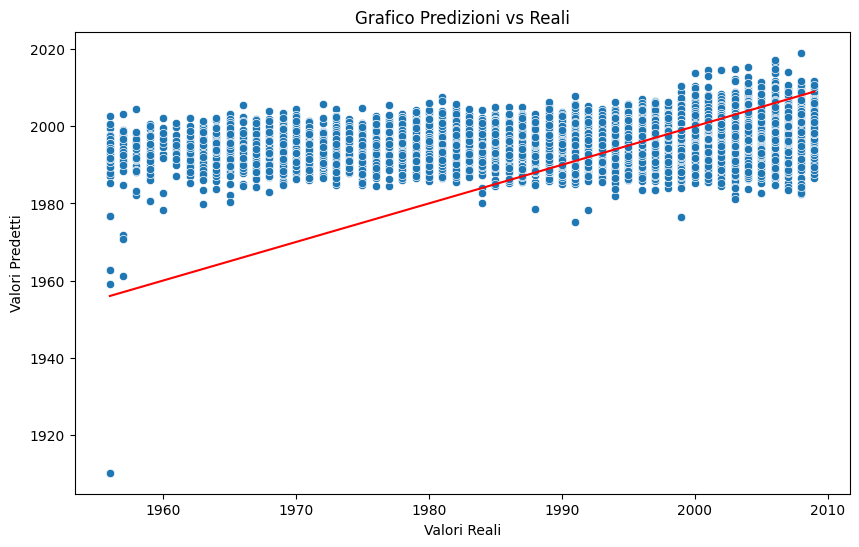

In [14]:
test_pred = tabular_model.predict(test)
result = tabular_model.evaluate(test)

results_df = test.copy()
results_df['Predicted_Year'] = test_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year', y='Predicted_Year', data=results_df)
plt.plot([results_df['Year'].min(), results_df['Year'].max()],
         [results_df['Year'].min(), results_df['Year'].max()],
         color='red', linestyle='-')
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Grafico Predizioni vs Reali')
plt.show()